In [1]:
# Essentials
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Tools
from IPython.display import clear_output
import copy
import sys
import importlib

# Specialized packages
from casadi import *
from casadi.tools import *

# Plotting
from matplotlib.animation import FuncAnimation, ImageMagickFileWriter
from cycler import cycler
import time as time
# Visualization
from mpl_toolkits.mplot3d import Axes3D
import droneplot

# Control packages
import do_mpc
import control

# Drone stuff
from droneplot.uav import Uav
importlib.reload(droneplot.uav)



<module 'droneplot.uav' from '/Users/felixfiedler/Documents/git_repos/2022_do_mpc_paper/01_Example_Systems/droneplot/uav.py'>

In [2]:
%matplotlib qt

# Quadcopter

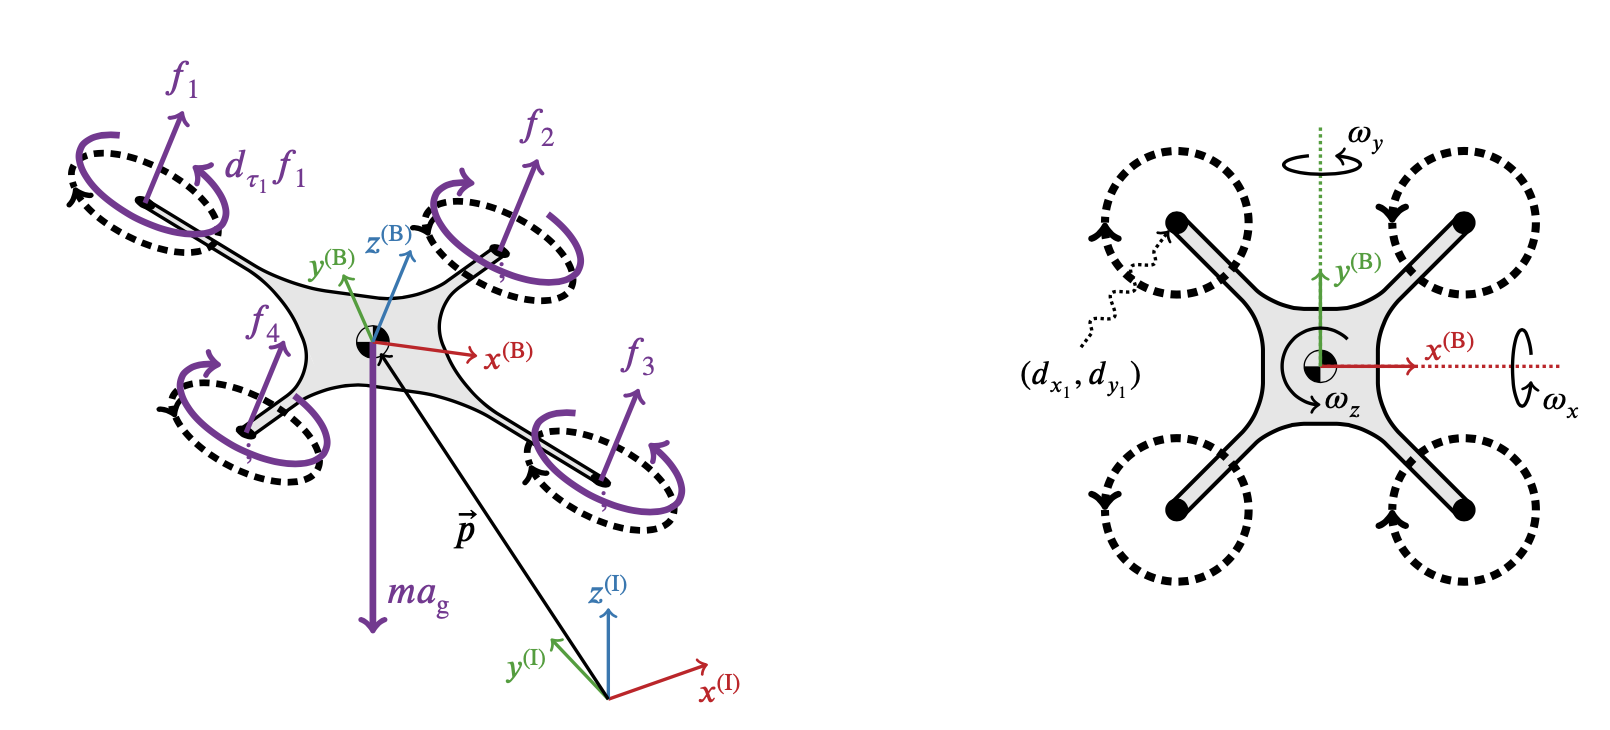

\begin{align}
\ddot p = 
\frac{1}{m}\sum_{i=1}^4 f_i
\begin{bmatrix}
\cos(\alpha)\sin(\beta)\sin(\gamma)+\sin(\alpha)\cos(\gamma)\\
\sin(\alpha)\sin(\beta)\cos(\gamma)-\cos(\alpha)\sin(\gamma)\\
\cos(\beta)\cos(\gamma)
\end{bmatrix}
\end{align}

\begin{align}
\dot \omega = 
J^{-1}
\left(
\underbrace{
\begin{bmatrix}
d_{y_1}& d_{y_2}& d_{y_3}& d_{y_4}\\
d_{x_1}& d_{x_2}& d_{x_3}& d_{x_4}\\
d_{\tau}& -d_{\tau}& d_{\tau}& -d_{\tau}\\
\end{bmatrix}
}_{D}
\begin{bmatrix}
f_1\\
f_2\\
f_3\\
f_4
\end{bmatrix}
-\omega\times J\omega\right)
\end{align}

\begin{align}
\dot \phi = R(\phi)\omega
\end{align}

## Model

In [3]:
import importlib

import quadcopter
importlib.reload(quadcopter)

qc = quadcopter.Quadcopter()
#qc = quadcopter.BiasedQuadcopter()
#qc = quadcopter.MeasuredBiasedQuadcopter()

model = qc.get_model()

## Stable equilibrium

Determine a stable equilibrium of the system by solving the problem:

$$
\begin{align}
\min_x\quad &\left(x_{\text{pos}}-x_{\text{pos}}^{\text{set}}\right)^2\\
\text{s.t.}\quad & \dot x = 0
\end{align}
$$

In [4]:
%%capture
pos_setpoint = np.array([1,1,2])
x_lin, u_lin = qc.stable_point(pos_setpoint=pos_setpoint)

In [5]:
print(f'u_lin at setpoint: {u_lin.flatten()}')

u_lin at setpoint: [0.06867 0.06867 0.06867 0.06867]


## Simulator

Setup simulator

In [6]:
simulator = do_mpc.simulator.Simulator(model)

t_step=0.05
simulator.set_param(t_step = t_step)
# Pass dummy tvp function (these wont affect the simulation)
simulator.set_tvp_fun(lambda t: simulator.get_tvp_template())

simulator.setup()

# MPC controller

In [7]:
mpc = do_mpc.controller.MPC(model)

setup_mpc = {
    'n_horizon': 30,
    't_step': t_step,   
    'store_full_solution': True,
    # Use MA27 linear solver in ipopt for faster calculations:
    'nlpsol_opts': {'ipopt.linear_solver': 'mumps'}
}
mpc.set_param(**setup_mpc)

surpress_ipopt = {'ipopt.print_level':0, 'ipopt.sb': 'yes', 'print_time':0}
mpc.set_param(nlpsol_opts = surpress_ipopt)
mpc_tvp_template = mpc.get_tvp_template()
mpc.set_tvp_fun(lambda t: mpc_tvp_template)



lterm  = sum1((model.x['pos'] -  model.tvp['pos_setpoint'])**2) * model.tvp['setpoint_weight', 0]
lterm += sum1((model.x['dpos']- model.tvp['dpos_setpoint'])**2) * model.tvp['setpoint_weight', 1]
lterm += 1*sum1((model.x['phi'])**2)

mterm = 10*lterm
mterm += 10*sum1((model.x['dpos'])**2)
mterm += 10*sum1((model.x['omega'])**2)


mpc.set_objective(lterm=lterm, mterm=mterm)
mpc.set_rterm(thrust=10)


mpc.bounds['lower','_u','thrust'] = 0
mpc.bounds['upper','_u','thrust'] = 0.15

mpc.setup()

In [8]:
mpc.reset_history()
simulator.reset_history()
x0_mpc = np.random.rand(12,1)*0.1
x0=copy.copy(x0_mpc)
mpc.x0 = x0
simulator.x0 = x0
mpc.set_initial_guess()

## Scenario 1: Fly to fixed position

In [9]:
mpc_tvp_template['_tvp', :, 'setpoint_weight', 0] = 10
mpc_tvp_template['_tvp', :, 'pos_setpoint'] = pos_setpoint

In [10]:
N_iter = 50
for k in range(N_iter):
    quadcopter.print_progress(k,N_iter)
    u0 = mpc.make_step(x0)
    x0 = simulator.make_step(u0)
    
mpc_res = copy.copy(simulator.data)

In [11]:
fig = plt.figure(figsize=(16,9))


ax3d = plt.subplot2grid((5,3), (0,0), colspan=2, rowspan=5, projection='3d')

ax = []
ax.append(plt.subplot2grid((5,3), (0,2), colspan=1, rowspan=1))
ax.append(plt.subplot2grid((5,3), (1,2), colspan=1, rowspan=1, sharex=ax[0]))
ax.append(plt.subplot2grid((5,3), (2,2), colspan=1, rowspan=1, sharex=ax[0]))
ax.append(plt.subplot2grid((5,3), (3,2), colspan=1, rowspan=1, sharex=ax[0]))
ax.append(plt.subplot2grid((5,3), (4,2), colspan=1, rowspan=1, sharex=ax[0]))


ax[0].plot(mpc_res['_time'],mpc_res['_x','pos'])
ax[1].plot(mpc_res['_time'],mpc_res['_x','dpos'])
ax[2].plot(mpc_res['_time'],mpc_res['_x','phi'])
ax[3].plot(mpc_res['_time'],mpc_res['_x','omega'])
ax[4].step(mpc_res['_time'],mpc_res['_u','thrust'])

for k in range(4):
    ax[4].axhline(u_lin[k],color='k',linestyle='--')

ax[4].set_xlabel('time [s]')
ax[0].set_ylabel('position [m]')
ax[1].set_ylabel('velocity [m/s]')
ax[2].set_ylabel('phi [rad]')
ax[3].set_ylabel('omega [rad/s]')
ax[4].set_ylabel('thrust [N]')

uav = Uav(ax3d, quadcopter=qc, scale=10)
uav.draw_at(mpc.data['_x','pos'][-1], quadcopter.rot_mat(*mpc.data['_x','phi'][-1]).full())

ax3d.plot(
    mpc.data['_x','pos',0].flatten(),
    mpc.data['_x','pos',1].flatten(),
    mpc.data['_x','pos',2].flatten()
    )

ax3d.axes.set_xlim3d(-1.5, 1.5) 
ax3d.axes.set_ylim3d(-1.5, 1.5)
ax3d.axes.set_zlim3d(bottom=0, top=3) 

fig.tight_layout()

